In [1]:
import numpy as np
import gplately
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
reconstruction_times = np.arange(0,171)

__Create a histogram of fz magnitudes and ages__

In [3]:
fz_counts = np.zeros(reconstruction_times.size)
fz_magnitudes = np.zeros((reconstruction_times.size, 3))

with np.load("subducted_fz_data.npz", "r") as npz:
    for i, time in enumerate(reconstruction_times):
        # extract lon, lat, mag fracture zone data for a given age
        fz_data = npz[str(int(time))]
        fz_lons, fz_lats, fz_mag = fz_data
        
        fz_counts[i] = len(fz_lons)
        fz_magnitudes[i] = np.percentile(fz_mag, 5), fz_mag.mean(), np.percentile(fz_mag, 95)

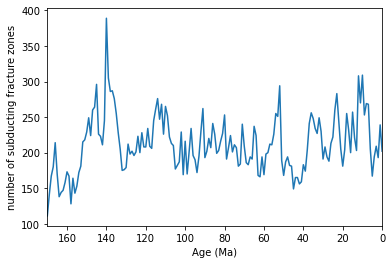

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[170,0], xlabel='Age (Ma)', ylabel='number of subducting fracture zones')
ax1.plot(reconstruction_times, fz_counts)

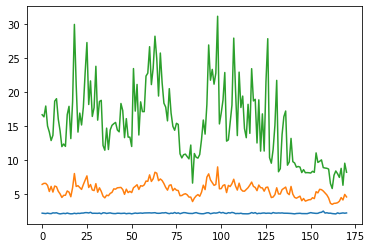

In [5]:
plt.plot(reconstruction_times, fz_magnitudes[:,0])
plt.plot(reconstruction_times, fz_magnitudes[:,1])
plt.plot(reconstruction_times, fz_magnitudes[:,2])

__Histograms for deposit ages__

In [30]:
metal_dict = dict()

commodities = ['Cu (Mt)', 'Pb (Mt)', 'Zn (Mt)', 'Ni (Mt)']
sheets = ['VMS', 'Cu-por']

for sheet in sheets:
    df = pd.read_excel('data/base_metal_deposit_compilation_processed.xlsx', sheet_name=sheet, na_values='ND')
    df = df[df['Age (Ga)'].notna()]
    df = df[df['Age (Ga)']*1000 <= reconstruction_times.max()]

    if df.shape[0] > 0:
        metal_dict[sheet] = df
    else:
        sheets.remove(sheet)
        
symbols = ['o', 'v', 's', '*', 'd', '^', 'P']*2

In [31]:
df_por = metal_dict['Cu-por']
df_vms = metal_dict['VMS']

(array([57., 74., 33., 62., 23., 47., 41., 19., 18.,  6.,  8.,  4.,  3.,
         7., 10.,  8.,  8.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170.]),
 <BarContainer object of 17 artists>)

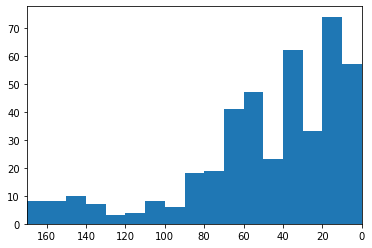

In [32]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[170,0])
ax1.hist(df_por['Age (Ga)']*1000, range=(0, 170), bins=17)

(array([ 3., 22.,  3.,  1.,  8.,  8.,  1.,  7.,  8., 49.,  5.,  6.,  7.,
         4.,  9., 17.,  4.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170.]),
 <BarContainer object of 17 artists>)

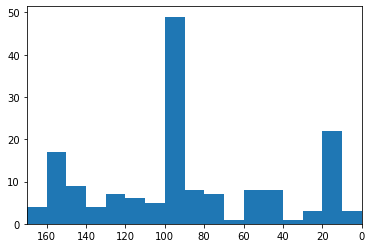

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[170,0])
ax1.hist(df_vms['Age (Ga)']*1000, range=(0, 170), bins=17)

In [34]:
def cdf_distance(dist, size):
    idx_sort = dist.argsort()
    dist = dist[idx_sort].copy()
    size = size[idx_sort].copy()
    size /= size.sum()
    cumsum_size = np.cumsum(size)
    return dist, cumsum_size

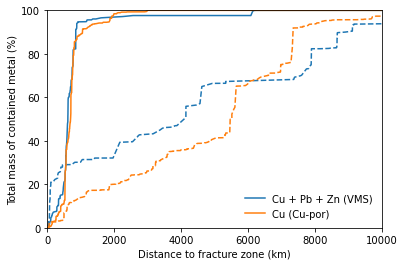

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(111, xlim=[0,10000], ylim=[0,100])
ax1.set_xlabel('Distance to fracture zone (km)')
ax1.set_ylabel('Total mass of contained metal (%)')


for i, sheet in enumerate(sheets):
    df = metal_dict[sheet]
    
    # create label for each sheet and add commodities
    label = ""
    size  = np.zeros(df.shape[0])
    for commodity in commodities:
        if commodity in df:
            label += "{} + ".format(commodity[:-5])
            size  += df[commodity].fillna(0.0).to_numpy()
    label = label[:-3] + " ({})".format(sheet)
    
    dist = df['distance_to_deposit'].to_numpy(copy=True)
    dist_to_deposit, cumsize_deposit = cdf_distance(dist, size)
    
    # cumulative distribution of subduction zone background
    dist = df['distance_to_trench'].to_numpy(copy=True)
    dist_to_trench, cumsize_trench = cdf_distance(dist, size)

    # stretch out to the maximum distance range
    dmin, dmax = ax1.get_xlim()
    dist_to_deposit = np.hstack([dist_to_deposit, [dmax]])
    cumsize_deposit = np.hstack([cumsize_deposit, [1]])
    dist_to_trench  = np.hstack([dist_to_trench,  [dmax]])
    cumsize_trench  = np.hstack([cumsize_trench,  [1]])
    
    
    ax1.plot(dist_to_deposit, cumsize_deposit*100, c='C{}'.format(i), label=label)
    ax1.plot(dist_to_trench,  cumsize_trench*100,  c='C{}'.format(i), linestyle='--')
    
ax1.legend(frameon=False)
# fig.savefig("fz_deposit_cdf.pdf", bbox_inches='tight', dpi=300)